# Calculate Automation Probabilities of Jobs on the Swiss Labour Market

## Content
1. [Import Data](#import)
2. [Normalize the Data](#normalize)
3. [Calculate Weighted Sum from Coefficients](#weighted-sum)
4. [Calculate Probability of Automation](#probability)
5. [Display Results](#display)
6. [Save Results](#save)

In [136]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math as m

<a id='import'></a>
## Import Data

In [137]:
# Replace 'filename.csv' with the path to your CSV file
df_swiss_jobs = pd.read_csv('files/switzerland_occupations.csv')
coefficients_outside_95 = pd.read_csv('files/coefficients.csv')
intercept = pd.read_csv('files/intercept.csv').iloc[0, 0]
not_automatable = [item[0] for item in pd.read_csv("files/not_automatable.csv").values.tolist()]

In [138]:
df_swiss_jobs.head(2)

,isco08,Name_de,Berufshauptgruppe,s1,s2,s3,s4,s5,s6,s7,...,a43,a44,a45,a46,a47,a48,a49,a50,a51,a52
0,2655,Schauspieler,2,0.72,0.72,0.69,0.69,0.50,0.50,0.50,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2612,Richter,2,0.81,0.75,0.81,0.72,0.81,0.66,0.56,...,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
coefficients_outside_95.head(2)

,id,coefficient
0,a27,-1.305062
1,a31,-1.236204


In [140]:
cols_to_keep = not_automatable
cols_to_keep.extend(['isco08', 'Name_de', 'Berufshauptgruppe'])

# Drop the other columns
df_swiss_jobs = df_swiss_jobs[cols_to_keep]

# Display the first few rows of the DataFrame
df_swiss_jobs.head(5)

,s27,s15,s8,s31,s26,s24,a40,isco08,Name_de,Berufshauptgruppe
0,0.00,0.38,0.47,0.0,0.00,0.06,0.03,2655,Schauspieler,2
1,0.00,0.56,0.72,0.0,0.00,0.19,0.06,2612,Richter,2
2,0.28,0.38,0.63,0.5,0.41,0.28,0.25,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3
3,0.00,0.44,0.75,0.0,0.00,0.22,0.13,2120,"Mathematiker, Aktuare und Statistiker",2
4,0.00,0.53,0.63,0.0,0.03,0.19,0.19,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1


<a id='normalize'></a>
## Normalize the Data

In [141]:
# Initialize a scaler
scaler = StandardScaler()

# Define the columns to scale
cols_to_scale = [col for col in df_swiss_jobs.columns if col not in ['isco08', 'Name_de',"Berufshauptgruppe"]]

# Scale only these columns
df_swiss_jobs_scaled = df_swiss_jobs.copy()
df_swiss_jobs_scaled[cols_to_scale] = scaler.fit_transform(df_swiss_jobs[cols_to_scale])

df_swiss_jobs_scaled.head(5)

,s27,s15,s8,s31,s26,s24,a40,isco08,Name_de,Berufshauptgruppe
0,-0.484664,-0.221735,-0.634561,-1.468928,-1.079571,-1.339385,-1.641511,2655,Schauspieler,2
1,-0.484664,1.120839,1.380598,-1.468928,-1.079571,0.150205,-1.384785,2612,Richter,2
2,1.623438,-0.221735,0.655141,0.816395,1.245401,1.181460,0.241149,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3
3,-0.484664,0.225790,1.622417,-1.468928,-1.079571,0.493957,-0.785757,2120,"Mathematiker, Aktuare und Statistiker",2
4,-0.484664,0.897077,0.655141,-1.468928,-0.909451,0.150205,-0.272304,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1


<a id='weighted-sum'></a>
## Calculate Weighted Sum from Coefficients

In [142]:
# Create a dictionary from the coefficients DataFrame
coef_dict = coefficients_outside_95.set_index('id')['coefficient'].to_dict()

In [143]:
# Filter coef_dict to only include keys present in df_swiss_jobs_scaled's columns
# Exclude 'fo_probability' and 'fo_computerisation'
filtered_coef_dict = {k: coef_dict[k] for k in df_swiss_jobs_scaled.columns if k in coef_dict and k not in ['Name_de', 'isco08',"Berufshauptgruppe"]}

# Create a list of weights in the same order as the DataFrame columns
weights = [filtered_coef_dict[col] for col in df_swiss_jobs_scaled.columns if col in filtered_coef_dict]

# Convert the DataFrame to a numpy array
df_array = df_swiss_jobs_scaled[filtered_coef_dict.keys()].values

# Calculate the weighted sum using np.dot
weighted_sum = np.dot(df_array, weights)

# Save the weighted sum in the DataFrame
df_swiss_jobs_scaled['weighted_sum'] = weighted_sum

df_swiss_jobs_scaled.head(5)

,s27,s15,s8,s31,s26,s24,a40,isco08,Name_de,Berufshauptgruppe,weighted_sum
0,-0.484664,-0.221735,-0.634561,-1.468928,-1.079571,-1.339385,-1.641511,2655,Schauspieler,2,-2.351973
1,-0.484664,1.120839,1.380598,-1.468928,-1.079571,0.150205,-1.384785,2612,Richter,2,0.184069
2,1.623438,-0.221735,0.655141,0.816395,1.245401,1.181460,0.241149,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3,0.954004
3,-0.484664,0.225790,1.622417,-1.468928,-1.079571,0.493957,-0.785757,2120,"Mathematiker, Aktuare und Statistiker",2,1.254621
4,-0.484664,0.897077,0.655141,-1.468928,-0.909451,0.150205,-0.272304,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1,0.247012


<a id='probability'></a>
## Calculate Probability of Automation

In [144]:
# Calculate the probabilities
prob_list = [m.exp(x_i + intercept) / (1 + m.exp(x_i + intercept)) for x_i in weighted_sum]

In [145]:
# Add the probabilities to the DataFrame
df_swiss_jobs_scaled['probability'] = prob_list

df_swiss_jobs_scaled.head(5)

,s27,s15,s8,s31,s26,s24,a40,isco08,Name_de,Berufshauptgruppe,weighted_sum,probability
0,-0.484664,-0.221735,-0.634561,-1.468928,-1.079571,-1.339385,-1.641511,2655,Schauspieler,2,-2.351973,0.065087
1,-0.484664,1.120839,1.380598,-1.468928,-1.079571,0.150205,-1.384785,2612,Richter,2,0.184069,0.467873
2,1.623438,-0.221735,0.655141,0.816395,1.245401,1.181460,0.241149,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3,0.954004,0.655036
3,-0.484664,0.225790,1.622417,-1.468928,-1.079571,0.493957,-0.785757,2120,"Mathematiker, Aktuare und Statistiker",2,1.254621,0.719477
4,-0.484664,0.897077,0.655141,-1.468928,-0.909451,0.150205,-0.272304,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1,0.247012,0.483570


<a id='display'></a>
## Display Results

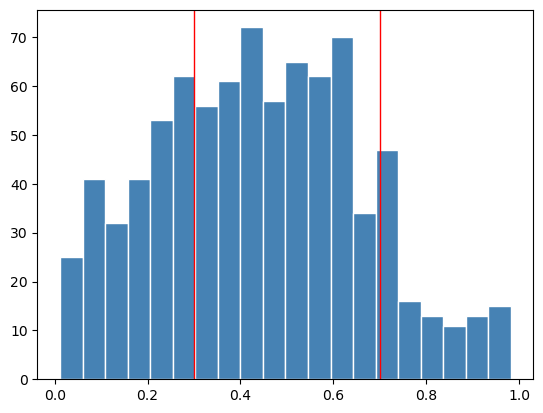

In [146]:
# Get the values
x = df_swiss_jobs_scaled["probability"].values

# Calculate the histogram
hist, bins = np.histogram(x, bins=20)

# Calculate the width and center of the bars
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# Plot the histogram
plt.bar(center, hist, align='center', width=width, color='#4682B4', edgecolor='white')

# Add lines at 0.3 and 0.7
plt.axvline(0.3, color='r', linewidth=1)
plt.axvline(0.7, color='r', linewidth=1)

# Show the plot
plt.show()

In [147]:
# Jobs with probability below 0.3
jobs_below_03 = df_swiss_jobs_scaled[df_swiss_jobs_scaled['probability'] <= 0.3]
print(f"Number of jobs with probability below 0.3: {len(jobs_below_03)}")

# Jobs with probability between 0.3 and 0.7
jobs_between_03_and_07 = df_swiss_jobs_scaled[(df_swiss_jobs_scaled['probability'] > 0.3) & (df_swiss_jobs_scaled['probability'] <= 0.7)]
print(f"Number of jobs with probability between 0.3 and 0.7: {len(jobs_between_03_and_07)}")

# Jobs with probability above 0.7
jobs_above_07 = df_swiss_jobs_scaled[df_swiss_jobs_scaled['probability'] > 0.7]
print(f"Number of jobs with probability above 0.7: {len(jobs_above_07)}")

Number of jobs with probability below 0.3: 252
Number of jobs with probability between 0.3 and 0.7: 491
Number of jobs with probability above 0.7: 103


In [148]:
df_swiss_jobs_scaled.head(2)

,s27,s15,s8,s31,s26,s24,a40,isco08,Name_de,Berufshauptgruppe,weighted_sum,probability
0,-0.484664,-0.221735,-0.634561,-1.468928,-1.079571,-1.339385,-1.641511,2655,Schauspieler,2,-2.351973,0.065087
1,-0.484664,1.120839,1.380598,-1.468928,-1.079571,0.150205,-1.384785,2612,Richter,2,0.184069,0.467873


<a id='save'></a>
## Save Results

In [149]:
df_probabilities = df_swiss_jobs_scaled[['Name_de', 'Berufshauptgruppe', 'probability', "isco08"]].copy()
df_pytorch_model = df_swiss_jobs_scaled.drop(columns=["weighted_sum"])

In [150]:
df_probabilities['probability'] = df_probabilities['probability'].round(4)
df_probabilities.to_csv('files/switzerland_probabilities.csv', index=False)